In [1]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt

# Rectify and undistort images

## Load images and extract object and image points

In [2]:
nb_vertical = 6
nb_horizontal = 9

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nb_horizontal*nb_vertical,3), np.float32)
objp[:,:2] = np.mgrid[0:nb_vertical,0:nb_horizontal].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpointsL = [] # 2d points in image plane.
imgpointsR = [] # 2d points in image plane.

images_l = glob.glob('Stereo_calibration_images/left-*.png')
images_r = glob.glob('Stereo_calibration_images/right-*.png')

left_count = len(images_l)
print('# of left images:', left_count)
right_count = len(images_r)
print('# of left images:', right_count)

# of left images: 50
# of left images: 50


In [3]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
for i in range(left_count):
    imgL = cv2.imread(images_l[i])
    imgR = cv2.imread(images_r[i])
    grayL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
    grayR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)

    outputL = imgL.copy()
    outputR = imgR.copy()

    retR, cornersR =  cv2.findChessboardCorners(outputR,(nb_vertical,nb_horizontal),None)
    retL, cornersL = cv2.findChessboardCorners(outputL,(nb_vertical,nb_horizontal),None)

    if retR and retL:
        objpoints.append(objp)
        imgpointsL.append(cornersL)
        imgpointsR.append(cornersR)
        
        cv2.cornerSubPix(grayR,cornersR,(11,11),(-1,-1),criteria)
        cv2.cornerSubPix(grayL,cornersL,(11,11),(-1,-1),criteria)
        cv2.drawChessboardCorners(outputR,(9,6),cornersR,retR)
        cv2.drawChessboardCorners(outputL,(9,6),cornersL,retL)
        cv2.imshow('cornersR',outputR)
        cv2.imshow('cornersL',outputL)
        cv2.waitKey(150)
        
cv2.destroyAllWindows()

## Calibrate cameras

In [4]:
# calibrating left and right camera
retL, mtxL, distL, rvecsL, tvecsL = cv2.calibrateCamera(objpoints, imgpointsL, grayL.shape[::-1], None, None)
retR, mtxR, distR, rvecsR, tvecsR = cv2.calibrateCamera(objpoints, imgpointsR, grayR.shape[::-1], None, None)

In [5]:
flags = 0
#flags |= cv2.CALIB_FIX_INTRINSIC
flags |= cv2.CALIB_USE_INTRINSIC_GUESS
#flags |= cv2.CALIB_FIX_PRINCIPAL_POINT
flags |= cv2.CALIB_FIX_FOCAL_LENGTH
flags |= cv2.CALIB_FIX_ASPECT_RATIO
flags |= cv2.CALIB_SAME_FOCAL_LENGTH
flags |= cv2.CALIB_ZERO_TANGENT_DIST
#flags |= cv2.CALIB_FIX_K1,...,cv2.CALIB_FIX_K6
flags |= cv2.CALIB_RATIONAL_MODEL
criteria_stereo = (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 30, 0.001)

In [6]:
# This step is performed to calculate the transformation between the two cameras and calculate Essential and Fundamenatl matrix
ret, newcameramtxL, distL, newcameramtxR, distR, R, T, E, F = \
    cv2.stereoCalibrate(objpoints, 
                        imgpointsL, imgpointsR, 
                        mtxL, distL, mtxR, distR, 
                        grayL.shape,
                        criteria=criteria_stereo,
                        flags=flags)

In [7]:
# Once we know the transformation between the two cameras we can perform stereo rectification
R1, R2, P1, P2, Q, roi_left, roi_right = \
    cv2.stereoRectify(newcameramtxL, distL, 
                      newcameramtxR, distR,
                      grayL.shape[::-1], 
                      R, T, 
                      flags = cv2.CALIB_ZERO_DISPARITY,
                      alpha = -1)

In [8]:
# Compute the mapping required to obtain the undistorted rectified stereo image pair
xmapL, ymapL = cv2.initUndistortRectifyMap(newcameramtxL, distL, 
                                           R1, P1, 
                                           grayL.shape[::-1], 
                                           cv2.CV_16SC2)
xmapR, ymapR = cv2.initUndistortRectifyMap(newcameramtxR, distR, 
                                           R2, P2, 
                                           grayR.shape[::-1], 
                                           cv2.CV_16SC2)

In [9]:
imgL = cv2.imread('Stereo_calibration_images/left-0033.png')
imgR = cv2.imread('Stereo_calibration_images/right-0033.png')

In [10]:
rectL = cv2.remap(imgL, 
                  xmapL, ymapL, 
                  cv2.INTER_LANCZOS4, 
                  cv2.BORDER_CONSTANT, 
                  0)
rectR = cv2.remap(imgR, 
                  xmapR, ymapR, 
                  cv2.INTER_LANCZOS4, 
                  cv2.BORDER_CONSTANT, 
                  0)

Text(0.5, 1.0, 'Right image')

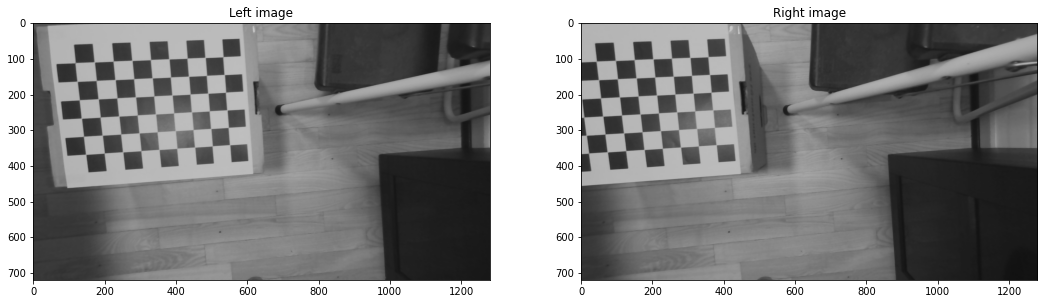

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,18))
ax[0].imshow(rectL, cmap='gray')
ax[0].set_title('Left image')
ax[1].imshow(rectR, cmap='gray')
ax[1].set_title('Right image')

In [12]:
out = rectR.copy()
out[:,:,0] = rectR[:,:,0]
out[:,:,1] = rectR[:,:,1]
out[:,:,2] = rectL[:,:,2]
cv2.imshow("Output image", out)
cv2.waitKey(1000)
cv2.destroyAllWindows()

## Save rectified images

In [13]:
dist_occ_path = 'C:/Users/Dimosthenis/Documents/DTU/Courses/3. Semester 2 - February 2022/31392 - Perception for autonomous systems/Perception_final_project/vid_w_o/'
dist_path = 'C:/Users/Dimosthenis/Documents/DTU/Courses/3. Semester 2 - February 2022/31392 - Perception for autonomous systems/Perception_final_project/vid_wo_o/'
dist_list = [dist_occ_path, dist_path]

In [32]:
for j in range(2):
    path = dist_list[j]
    print(path)
    
    templ = path + 'left/*.png'
    tempr = path + 'right/*.png'
    images_l = glob.glob(templ)
    images_r = glob.glob(tempr)
    for i in range(len(images_l)):
        imgL = cv2.imread(images_l[i])
        imgR = cv2.imread(images_r[i])

        rectL = cv2.remap(imgL, 
                          xmapL, ymapL, 
                          cv2.INTER_LANCZOS4, 
                          cv2.BORDER_CONSTANT, 
                          0)
        rectR = cv2.remap(imgR, 
                          xmapR, ymapR, 
                          cv2.INTER_LANCZOS4, 
                          cv2.BORDER_CONSTANT, 
                          0)
        
        rectL_str = str(i)+'.jpg'
        cv2.imwrite(images_l[i].replace('\\', '/').replace('left', 'left_undistorted'), rectL)

        rectR_str = str(i)+'.jpg'
        cv2.imwrite(images_r[i].replace('\\', '/').replace('right', 'right_undistorted'), rectR)

C:/Users/Dimosthenis/Documents/DTU/Courses/3. Semester 2 - February 2022/31392 - Perception for autonomous systems/Perception_final_project/vid_w_o/
C:/Users/Dimosthenis/Documents/DTU/Courses/3. Semester 2 - February 2022/31392 - Perception for autonomous systems/Perception_final_project/vid_wo_o/


# Create list of images

In [28]:
w_occ_left   = list(glob.glob('C:/Users/Dimosthenis/Documents/DTU/Courses/3. Semester 2 - February 2022/31392 - Perception for autonomous systems/Perception_final_project/vid_w_o/left_undistorted/*.png'))
w_occ_right  = list(glob.glob('C:/Users/Dimosthenis/Documents/DTU/Courses/3. Semester 2 - February 2022/31392 - Perception for autonomous systems/Perception_final_project/vid_w_o/right_undistorted/*.png'))
wo_occ_left  = list(glob.glob('C:/Users/Dimosthenis/Documents/DTU/Courses/3. Semester 2 - February 2022/31392 - Perception for autonomous systems/Perception_final_project/vid_wo_o/left_undistorted/*.png'))
wo_occ_right = list(glob.glob('C:/Users/Dimosthenis/Documents/DTU/Courses/3. Semester 2 - February 2022/31392 - Perception for autonomous systems/Perception_final_project/vid_wo_o/right_undistorted/*.png'))

print(len(w_occ_left))
print(len(w_occ_right))
print(len(wo_occ_left))
print(len(wo_occ_right))

1453
1453
1567
1567


# Classification

In [66]:
import pickle

import matplotlib.pyplot as plt

import keras
import numpy
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
from pickle import dump

import cv2
import os

import numpy as np
import pandas as pd


def get_label(input):
    return labels[np.argmax(input)]

def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

def classify_frame(frame, model):
    frame = cv2.resize(frame, (256, 256))
    frame = tf.keras.preprocessing.image.img_to_array(frame)
    frame = np.array([frame])
    frame = tf.cast(frame/255. ,tf.float32)
    label = get_label(model.predict(frame))
        
    return label

# Object detection

## Kalman filter functions

In [26]:
def initialize_kalman():
    dt = 0.1

    # The initial state (6x1).
    x = np.array([[0], # Position along the x-axis
                  [0], # Velocity along the x-axis
                  [0], # acceleration along the x-axis
                  [0], # Velocity along the y-axis
                  [0], # Position along the y-axis
                  [0], # acceleration along the y-axis
                  [0], # Position along the z-axis
                  [0], # Velocity along the z-axis
                  [0]]) # acceleration along the z-axis])

    # The initial uncertainty (6x6).
    P = np.identity(9)*100

    # The external motion (6x1).
    u = np.array([[0], 
                  [0], 
                  [0], 
                  [0], 
                  [0], 
                  [0], 
                  [0], 
                  [0],
                  [0]])

    # The transition matrix (6x6). 
    F = np.array([[1,dt,(dt**2)/2,0,0,0,0,0,0],
                  [0,1,dt,0,0,0,0,0,0],
                  [0,0,1,0,0,0,0,0,0],
                  [0,0,0,1,dt,(dt**2)/2,0,0,0],
                  [0,0,0,0,1,dt,0,0,0],
                  [0,0,0,0,0,1,0,0,0],
                  [0,0,0,0,0,0,1,dt,(dt**2)/2],
                  [0,0,0,0,0,0,0,1,dt],
                  [0,0,0,0,0,0,0,0,1]])

    # The observation matrix (2x6).
    H = np.array([[1,0,0,0,0,0,0,0,0],
                  [0,0,0,1,0,0,0,0,0],
                  [0,0,0,0,0,0,1,0,0]])

    # The measurement uncertainty.
    R = [[1],
        [1],
        [1]]
    
    return x, P, u, F, H, R

def update(x, P, Z, H, R):
    y = Z - np.dot(H,x)
    S = np.linalg.multi_dot([H,P,H.transpose()]) + R
    K = np.linalg.multi_dot([P,H.transpose(),np.linalg.pinv(S)])
    x_new = x + np.dot(K,y)
    p_new = np.dot(np.identity(len(P)), P)
    return [np.asarray(x_new), np.asarray(p_new)]
    
def predict(x, P, F, u):
    x_new = np.dot(F,x) + u
    p_new = np.linalg.multi_dot([F,P,F.transpose()])
    return [np.asarray(x_new), np.asarray(p_new)]

## Depth estimation

In [75]:
# code

## Tracking and prediction

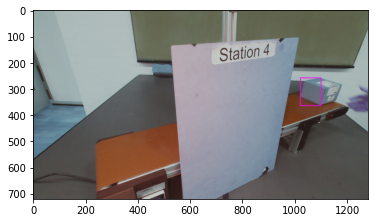

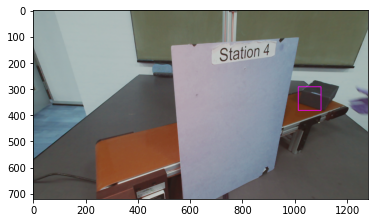

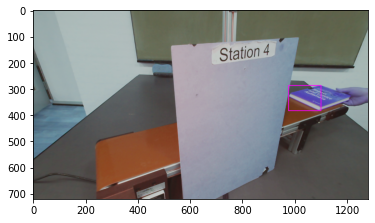

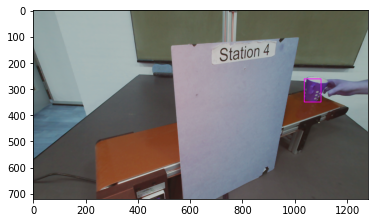

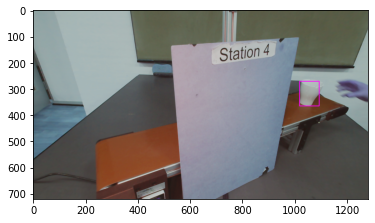

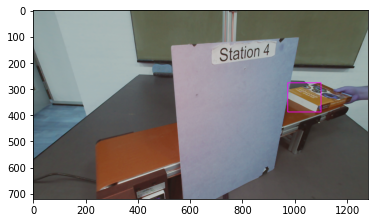

In [74]:
def detect_object(frame, object_detector):
    
    # Initialize variable to return
    boundRect = None
    bounding_box = None
    detected_object = False
    
    # Create mask
    mask = object_detector.apply(frame)
    
    # Erode it and dilate it to avoid small points
    kernel = np.ones((5,5), np.uint8) 
    mask = cv2.erode(mask, kernel, iterations=1) 
    mask = cv2.dilate(mask, kernel, iterations=1)
        
    # Find contours in image
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    prev_area = 0
    
    for cnt in contours:
        # Calculate the area of the specific contour
        area = cv2.contourArea(cnt)
        
        # Only look at contours with an area of over 2k pixels
#         if area > 2000 and area > prev_area:
        if area > 2000:
            # Detected object
            detected_object = True
            bounding_box = np.zeros(4)

            # Fit a circle around the contour to find the center
            center, radius = cv2.minEnclosingCircle(cnt)

            # Save the contour
            obj_cnt = cnt
            
            # Draw bounding rectangle
            boundRect = cv2.boundingRect(cnt)
            bounding_box[0] = boundRect[0]
            bounding_box[1] = boundRect[1]
            bounding_box[2] = boundRect[2]
            bounding_box[3] = boundRect[3]
            
            prev_area = area

    return frame, mask, bounding_box, detected_object

if __name__ == "__main__":
    # Search for new object crop
    new_count = 0
    object_area = None
    prev_center = [0,0]
    center = [0,0]
    radius = 2
    depth = 0
    
    # Load classification model
    model = keras.models.load_model('model_v6.h5')
    
    # Object detector
    object_detector1 = cv2.createBackgroundSubtractorKNN(history=1000, dist2Threshold=1000, detectShadows=False)
    object_detector2 = cv2.createBackgroundSubtractorKNN(history=1000, dist2Threshold=1000, detectShadows=False)

    # Loop through images 
    for img_name in w_occ_right:
        # Load the frame
        frame = cv2.imread(img_name)
        start_frame = frame[240:400,960:1100]

        ### Detect new object
        start_frame, _, init_BB , detected_new_object = detect_object(start_frame, object_detector1)
        
        if detected_new_object:
            new_count += 1
        else: 
            new_count = 0
            
        # if new object on conveyor
        if detected_new_object and new_count == 10:
            # Get bound for whole frame
            init_BB[0] += 960   # height
            init_BB[1] += 240   # width
            object_area = init_BB[2]*init_BB[3]
            object_height = init_BB[2]
            object_width = init_BB[3]
            center[0] = int(init_BB[0] + init_BB[2]/2)
            center[1] = int(init_BB[1] + init_BB[3]/2)
            prevx = center[0]
            prevRbound = init_BB[0] + init_BB[2]
            prevy = center[1]
            prevBbound = init_BB[1] + init_BB[3]
            
            cv2.rectangle(frame, (int(init_BB[0]), int(init_BB[1])), (int(init_BB[0]+init_BB[2]), int(init_BB[1]+init_BB[3])), (255, 0, 255), 2)
            plt.imshow(frame)
            plt.show()
            
            # Change counter so that it doesn't trigger the new object rule more than once for each object
            new_count = -1000
            
            # Initialize Kalman filter
            x, P, u, F, H, R = initialize_kalman()
            continue
            
        if not detected_new_object:
            new_count = -1
            
        ### Detect moving object on conveyor 
        search_frame = frame[240:600,200:1200]
        search_frame, _, BB , detected = detect_object(search_frame, object_detector2)
        
        if detected and object_area is not None:
            # If moving object is not occluded update kalman filter
            if object_area < BB[2]*BB[3]:
                center[0] = int(BB[0] + BB[2]/2)
                center[1] = int(BB[1] + BB[3]/2)
                ########## input depth ##########
                # depth = ...
                depth = 20
                if center[0] > 640:
                    center[0] = int(prevx + BB[0]+BB[2]-prevRbound)
                    center[1] = int(prevy + BB[1]+BB[3]-prevBbound)
                    prevx = center[0]
                    prevRbound = BB[0]+BB[2]
                    prevy = center[1]
                    prevBbound = BB[1]+BB[3]
                z = np.array([[center[0]], [center[1]], [depth]])
                [x, P] = update(x, P, z, H, R)
            
        if object_area is not None:
            # Draw previous state
            if detected:  
                cv2.rectangle(search_frame, (int(BB[0]), int(BB[1])), (int(BB[0] + BB[2]), int(BB[1] + BB[3])), (255, 0, 255), 2)
                
                ########## Classify the object ##########
                x1 = int(BB[0])
                x2 = int(BB[0]+BB[2])
                y1 = int(BB[1])
                y2 = int(BB[1]+BB[3])
                object_frame = search_frame[y1:y2,x1:x2]
                label = classify_frame(object_frame, model)
                cv2.putText(frame, label, (x1+200, y1+200), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

            # Predict next position
            [x, P] = predict(x, P, F, u)
            
            ### Draw the current tracked state 
            cv2.circle(search_frame, (int(x[0]), int(x[3])), int(radius), (0, 0, 255), 2)

        
        
        cv2.imshow('Frame', frame)
        k = cv2.waitKey(10)
        if k==27:    # Esc key to stop
            break

    cv2.destroyAllWindows()